In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

from orbit.utils.stan import get_compiled_stan_model_simplified, compile_stan_model_simplified
from orbit.utils.dataset import load_iclaims
import arviz as az

In [2]:
ss_model_path = "../stan/ss_local_level_boxcox.stan"
compiled_path = compile_stan_model_simplified(ss_model_path)
ss_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

Run the `load_data` first after downloading the data from kaggle m5 homepage.

In [28]:
raw_data = load_iclaims()
raw_y = raw_data['claims']
y = raw_y / np.mean(raw_y)
# y = (y - np.mean(y))/np.std(y)
sdy = np.std(y)

In [29]:
data = {
    'N': len(y),
    'Y' : y,
    'SD_Y' : sdy,
    'A1' : 0.0,
    'P1' : 0.0,
    'STATE_SIGMA_MEAN': 1.0,
    'STATE_SIGMA_SD': 1.0,
    'OBS_SIGMA_MEAN': 1.0,
    'OBS_SIGMA_SD': 1.0,
}

In [30]:
ss_fit = ss_mod.sampling(
    data=data,
    warmup=1000,
    iter=1100,
    chains=4,
)


Gradient evaluation took 0.00015 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000168 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000148 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.48 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:    1 / 1100 [  0%]  (Warmup)

Gradient evaluation took 0.000279 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.79 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  110 / 1100 [ 10%]  (Warmup)
Iteration:  220 / 1100 [ 2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


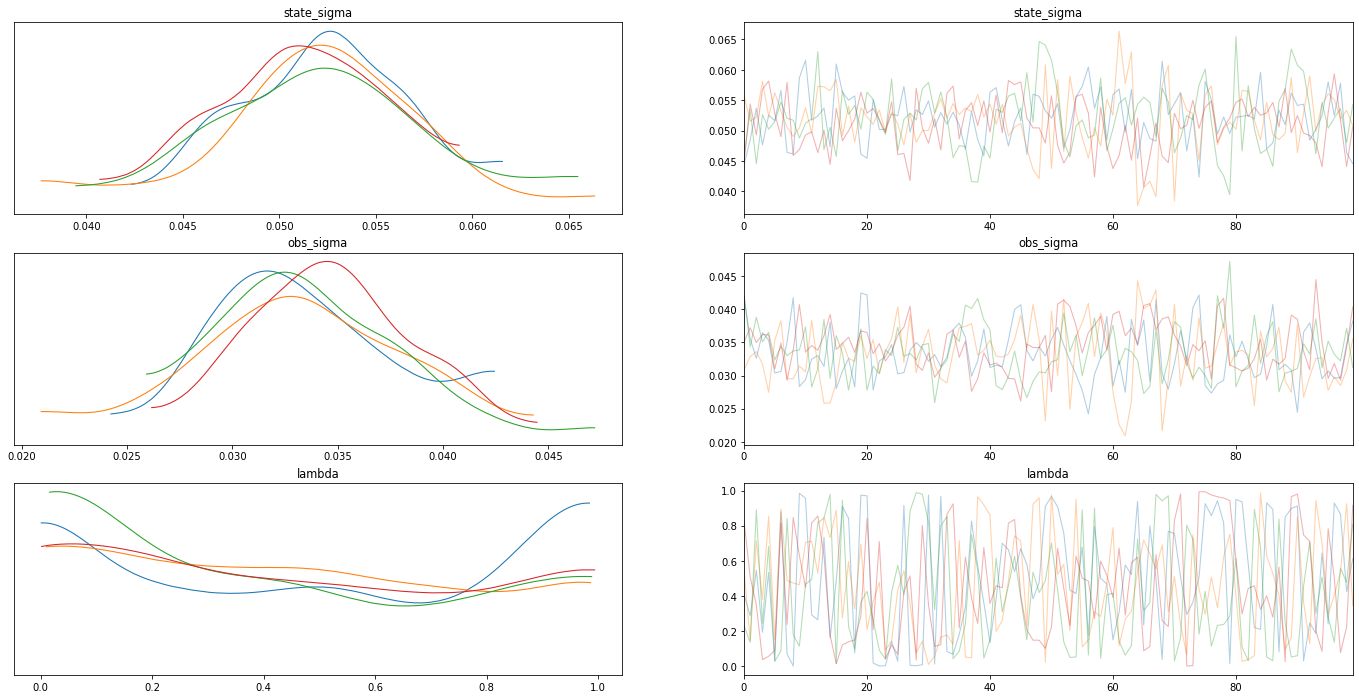

In [31]:
az_posteriors = az.from_pystan(ss_fit)
az.plot_trace(az_posteriors, var_names=['state_sigma', 'obs_sigma', 'lambda'], compact=False, figsize=(24, 12));

In [32]:
ss_posteriors = ss_fit.extract(pars=['state_sigma', 'states', 'obs_sigma', 'lambda'], permuted=True)
lambda_ = np.expand_dims(ss_posteriors['lambda'], -1)
states = ss_posteriors['states']

In [38]:
yhat = np.power(1 + lambda_ * states, 1 / lambda_)[:, :-1] * np.mean(raw_y)
yhat_upper, yhat_med, yhat_lower = np.quantile(yhat, q=[0.9, 0.5, 0.1], axis=0)

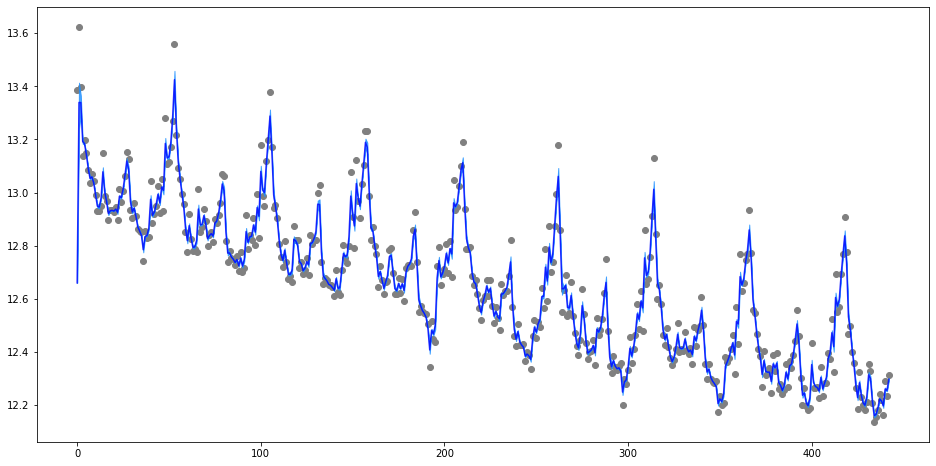

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, raw_y, c='grey')
ax.plot(x, yhat_med, color='blue', alpha=0.8);
ax.fill_between(x=x, y1=yhat_lower, y2=yhat_upper, color='dodgerblue', alpha=0.8);

In [11]:
ss_posteriors = ss_fit.extract(pars=['F'])
ss_posteriors['F'].mean()

0.2122981230111735